# 분류기(Classifier) 학습하기

`torchvision`을 이용해 CIFAR10 데이터셋을 불러와 이미지 분류기를 만들겠다.

## 이미지 분류기 학습하기

다음과 같은 단계로 진행된다.

1. `torchvision`을 사용하여 CIFAR10의 학습용/시험용 데이터셋을 불러오고, 정규화(nomarlizing)한다.
2. 합성곱 신경망(Convolution Neural Network)을 정의한다.
3. 손실 함수를 정의한다.
4. 학습용 데이터를 사용하여 신경망을 학습한다.
5. 시험용 데이터를 사용하여 신경망을 검사한다.

### CIFA10을 불러오고 정규화하기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                                 download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                                                  shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                                download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                                                 shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck', )

100.0%

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


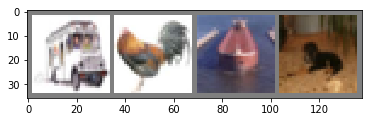

truck  bird  ship   dog


In [23]:
# 학습용 이미지 관찰하기
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 합성곱 신경망(Convolution Neural Network) 정의하기

In [32]:
images.size()

torch.Size([4, 3, 32, 32])

In [38]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # # of channels, # of feature maps, kernel size
        # valid padding, so size: 32 -> 28
        
        self.pool = nn.MaxPool2d(2, 2)  # kernel size, stride
        self.conv2 = nn.Conv2d(6, 16, 5)
        # valid padding, so size: 14 -> 10
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # # of channels, pre-output's height, pre-output's width 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 손실 함수와 Optimizer 정의하기

In [39]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 신경망 학습하기

In [40]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                     (epoch +1, i + 1, running_loss / 2000))
            running_loss = 0.0
print("Finished Training")

[1,  2000] loss: 2.236
[1,  4000] loss: 1.867
[1,  6000] loss: 1.667
[1,  8000] loss: 1.578
[1, 10000] loss: 1.526
[1, 12000] loss: 1.482
[2,  2000] loss: 1.442
[2,  4000] loss: 1.373
[2,  6000] loss: 1.362
[2,  8000] loss: 1.345
[2, 10000] loss: 1.330
[2, 12000] loss: 1.291
Finished Training


### 시험용 데이터로 신경망 검사하기

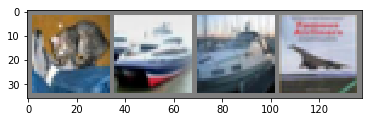

GroundTruth:    cat  ship  ship plane


In [45]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join('%5s' % classes[labels[j]] for j in range(4)))

In [46]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car   car plane


전체 데이터셋에 대해서 어떻게 동작하는지 살펴보기

In [47]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += lables.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the network on the 10000 test images: %d %%" % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [49]:
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        # squeeze는 size의 원소가 1인 차원을 없애주는 함수인데 여기서는 predicted==labels의
        # 차원 중에 size의 값이 1인 차원이 없기 때문에 굳이 안써도 될듯
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 75 %
Accuracy of  bird : 20 %
Accuracy of   cat : 19 %
Accuracy of  deer : 58 %
Accuracy of   dog : 58 %
Accuracy of  frog : 57 %
Accuracy of horse : 62 %
Accuracy of  ship : 57 %
Accuracy of truck : 63 %


In [59]:
print(c)
print(labels)
print((predicted == labels).size())
print((predicted == labels).squeeze().size())

tensor([ True,  True, False,  True])
tensor([3, 5, 1, 7])
torch.Size([4])
torch.Size([4])
